<a href="https://colab.research.google.com/github/sparks-baird/xtal2png/blob/main/notebooks/3.1-imagen-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using `xtal2png` with `imagen-pytorch`

In [7]:
!nvidia-smi

Fri Aug 19 20:12:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    696MiB / 15109MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%pip install mp-time-split xtal2png matbench-genmetrics imagen-pytorch==0.21.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 705 kB 10.2 MB/s 
     |████████████████████████████████| 117 kB 54.9 MB/s 
     |████████████████████████████████| 314 kB 60.7 MB/s 
     |████████████████████████████████| 4.7 MB 58.4 MB/s 
     |████████████████████████████████| 1.3 MB 68.9 MB/s 
     |████████████████████████████████| 561 kB 65.7 MB/s 
     |████████████████████████████████| 1.4 MB 59.5 MB/s 
     |████████████████████████████████| 40.6 MB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 58.1 MB/s 
     |████████████████████████████████| 79.9 MB 1.2 MB/s 
     |████████████████████████████████| 58 kB 6.5 MB/s 
     |████████████████████████████████| 81 kB 11.7 MB/s 
     |████████████████████████████████|

In [3]:
try:
  from google.colab import output
  output.enable_custom_widget_manager()
except Exception as e:
  print(e)
  pass

In [22]:
from os import path
from pathlib import Path
from uuid import uuid4
from tqdm import tqdm
import math

import numpy as np
import torch
from imagen_pytorch import ImagenConfig, ElucidatedImagenConfig, ImagenTrainer
from mp_time_split.core import MPTimeSplit

from xtal2png.core import XtalConverter

## Helper

In [5]:
from PIL import Image
def image_grid(imgs, rows, cols):
    """https://stackoverflow.com/questions/37921295/python-pil-image-make-3x3-grid-from-sequence-images
    https://stackoverflow.com/a/65583584/13697228
    """
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [32]:
import gc
from torch.cuda import empty_cache

def deallocate():
  if "trainer" in locals():
    try:
      del trainer
    except Exception as e:
      print(e)
      pass
  if "imagen" in locals():
    try:
      del imagen
    except Exception as e:
      print(e)
      pass
  if "training_images" in locals():
    try:
      del training_images
    except Exception as e:
      print(e)
      pass

  gc.collect()
  empty_cache()

## Data and `xtal2png` images

In [6]:
dummy = False #@param {type:"boolean"}

mpt = MPTimeSplit()
mpt.load(dummy=dummy)

fold = 0
train_inputs, val_inputs, train_outputs, val_outputs = mpt.get_train_and_val_data(fold)

xc = XtalConverter(encode_cell_type=None, decode_cell_type=None)
arrays, _, _ = xc.structures_to_arrays(train_inputs.tolist(), rgb_scaling=False)

Reading file /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_time_summary.json.gz: 0it [01:29, ?it/s]
Decoding objects from /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_time_summary.json.gz: 100%|##########| 40476/40476 [01:29<00:00, 452.86it/s]
100%|██████████| 5400/5400 [02:13<00:00, 40.58it/s]


## Training

In [25]:
if dummy:
  dummy_timesteps = 10 #@param {type:"integer"}
  dummy_epochs = 3 #@param {type:"integer"}
  dummy_checkpoint_rate = 2 #@param {type:"integer"}
  dummy_max_batch_size = 1 #@param {type:"integer"}
  timesteps = dummy_timesteps
  epochs = dummy_epochs
  checkpoint_rate = dummy_checkpoint_rate
else:
  timesteps = 1000 #@param {type:"integer"}
  epochs = 100 #@param {type:"integer"}
  checkpoint_rate = 10 #@param {type:"integer"}
  # `max_batch_size` suggested by lucidrains to be at least 32
  max_batch_size = 16 #@param {type:"integer"}

In [26]:
results_folder = path.join(
    "data",
    "interim",
    "imagen-pytorch",
    f"fold={fold}",
    # str(uuid4())[0:4],
)

Path(results_folder).mkdir(exist_ok=True, parents=True)
Path(path.join(results_folder, "checkpoint")).mkdir(exist_ok=True, parents=True)

In [38]:
deallocate() # free up CUDA memory of previously defined `imagen` and `trainer` if existing

training_images = torch.from_numpy(arrays).float().cuda()

imagen = ImagenConfig(
    condition_on_text=False,
    unets = [
        dict(dim = 128, dim_mults = (1, 2, 4, 8), memory_efficient=True),
        dict(dim = 64, dim_mults = (1, 2, 4, 8), memory_efficient=True),
    ],
    image_sizes = (32, 64),
    channels=1,
    cond_drop_prob = 0.5,
    timesteps = timesteps,
    # num_sample_steps = 32, # for ElucidatedImagenConfig, but ran into error
).create()

trainer = ImagenTrainer(imagen)

The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/


In [39]:
!nvidia-smi

Fri Aug 19 20:56:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    34W /  70W |   5420MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

  0%|          | 0/100 [00:00<?, ?it/s]

checkpoint saved to checkpoint_u1.pt


  1%|          | 1/100 [04:04<6:42:58, 244.23s/it]

checkpoint saved to checkpoint_u2.pt


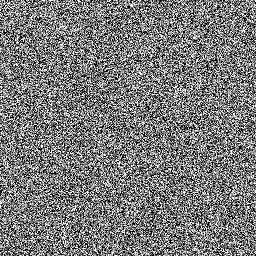

checkpoint saved to data/interim/imagen-pytorch/fold=0,epoch=0.pt
checkpoint saved to checkpoint_u1.pt


  2%|▏         | 2/100 [11:41<10:03:15, 369.35s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


  3%|▎         | 3/100 [15:44<8:23:45, 311.60s/it] 

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


  4%|▍         | 4/100 [19:46<7:35:09, 284.47s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


  5%|▌         | 5/100 [23:49<7:06:39, 269.47s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


  6%|▌         | 6/100 [27:53<6:48:11, 260.55s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


  7%|▋         | 7/100 [31:55<6:34:50, 254.74s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


  8%|▊         | 8/100 [35:58<6:24:47, 250.95s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


  9%|▉         | 9/100 [40:01<6:16:49, 248.45s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 10%|█         | 10/100 [44:04<6:10:02, 246.69s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 11%|█         | 11/100 [48:07<6:04:11, 245.52s/it]

checkpoint saved to checkpoint_u2.pt


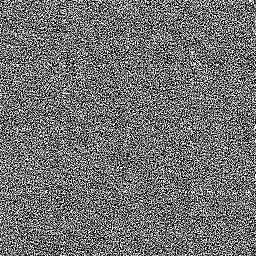

checkpoint saved to data/interim/imagen-pytorch/fold=0,epoch=10.pt
checkpoint saved to checkpoint_u1.pt


 12%|█▏        | 12/100 [55:43<7:34:12, 309.68s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 13%|█▎        | 13/100 [59:48<7:00:33, 290.03s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 14%|█▍        | 14/100 [1:03:51<6:35:19, 275.81s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 15%|█▌        | 15/100 [1:07:54<6:16:38, 265.87s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 16%|█▌        | 16/100 [1:11:56<6:02:27, 258.90s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 17%|█▋        | 17/100 [1:15:59<5:51:24, 254.03s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 18%|█▊        | 18/100 [1:20:02<5:42:29, 250.61s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 19%|█▉        | 19/100 [1:24:05<5:35:07, 248.25s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 20%|██        | 20/100 [1:28:08<5:28:55, 246.70s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 21%|██        | 21/100 [1:32:10<5:23:11, 245.46s/it]

checkpoint saved to checkpoint_u2.pt


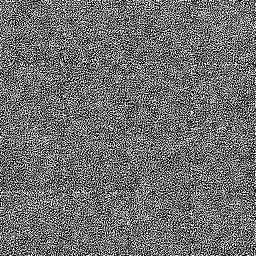

checkpoint saved to data/interim/imagen-pytorch/fold=0,epoch=20.pt
checkpoint saved to checkpoint_u1.pt


 22%|██▏       | 22/100 [1:39:47<6:41:24, 308.78s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 23%|██▎       | 23/100 [1:43:50<6:10:52, 288.99s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 24%|██▍       | 24/100 [1:47:53<5:48:37, 275.23s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 25%|██▌       | 25/100 [1:51:55<5:31:50, 265.47s/it]

checkpoint saved to checkpoint_u2.pt
checkpoint saved to checkpoint_u1.pt


 26%|██▌       | 26/100 [1:55:58<5:19:06, 258.74s/it]

checkpoint saved to checkpoint_u2.pt


In [ ]:
%%time
# capture the tqdm output (which keeps printing newlines) to avoid Colab crash
from IPython.utils import io
# train each unet in concert, or separately (recommended) to completion
l_arr = [[],[]]

with tqdm(total=epochs) as pbar:
  for epoch in range(epochs):
    for u in (1, 2):
      with io.capture_output() as captured:
        loss = trainer(training_images, unet_number=u, max_batch_size=max_batch_size)
        trainer.update(unet_number=u)
      l_arr[u-1].append(loss)
      trainer.save(f'checkpoint_u{u}.pt')
    pbar.update()
    if epoch % checkpoint_rate == 0:
      with io.capture_output() as captured:
        images = trainer.sample(batch_size=16, return_pil_images=True)
      display(image_grid(images, 4, 4))
      if not math.isnan(loss):
        trainer.save(results_folder + f",epoch={epoch}.pt")

## Sampling

In [25]:
with io.capture_output() as captured:
  images = trainer.sample(batch_size=16, return_pil_images=True)
  trainer.save(results_folder + "_end.pt")

## deallocate CUDA memory
https://discuss.pytorch.org/t/how-can-we-release-gpu-memory-cache/14530/28

In [17]:
!nvidia-smi

Fri Aug 19 20:44:58 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   1466MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------